## Test GAIA DR2

Test to search for specific data in DR2. <br>
Note that gaia-on-tap is by default for DR1 <br>

In [1]:
import sys, os
sys.path.append('../../src')

import astropy.coordinates as coord
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from gaia.tap import cone_search


import gaia_utils as gu

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/master/notebooks/data"%(rootdir)

os.chdir(wdir)

### OC selection 

In [2]:
def plotCluster(cluster_candidates, clustername, display = True):

    figname = "%s-gaia.png"%(clustername)
    
    rcParams['figure.figsize'] = 14, 21
    f, axarr = plt.subplots(3, 2)

# ax.scatter(cluster_candidates["ra"], cluster_candidates["dec"], s=1, c="#000000")
    axarr[0,0].scatter(cluster_candidates["ra"], cluster_candidates["dec"], s=1, c="#000000")
    axarr[0,0].set_xlabel(r"$\alpha$")
    axarr[0,0].set_ylabel(r"$\delta$")

    axarr[0,1].scatter(cluster_candidates["l"], cluster_candidates["b"], s=1, c="#000000")
    axarr[0,1].set_xlabel(r"l")
    axarr[0,1].set_ylabel(r"b")

    axarr[1,0].scatter(cluster_candidates["l"], cluster_candidates["parallax"], s=1, c="#000000")
    axarr[1,0].set_xlabel(r"l")
    axarr[1,0].set_ylabel(r"p (mas)")
    axarr[1,0].set_ylim([-1,4])

    axarr[1,1].scatter(cluster_candidates["ra"], cluster_candidates["pmra"], s=1, c="#000000")
    axarr[1,1].set_xlabel(r"$\alpha$")
    axarr[1,1].set_ylabel(r"PM RA (mas/yr)")
    axarr[1,1].set_ylim([-40,40])

    axarr[2,0].scatter(cluster_candidates["pmdec"], cluster_candidates["pmra"], s=1, c="#000000")
    axarr[2,0].set_xlabel(r"PM DEC (mas/yr)")
    axarr[2,0].set_ylabel(r"PM RA (mas/yr)")
    axarr[2,0].set_xlim([-40,40])
    axarr[2,0].set_ylim([-40,40])

    axarr[2,1].scatter(cluster_candidates["parallax"], cluster_candidates["pmra"], s=1, c="#000000")
    axarr[2,1].set_xlabel(r"p (mas)")
    axarr[2,1].set_ylabel(r"PM RA (mas/yr)")
    axarr[2,1].set_xlim([-1,4])
    axarr[2,1].set_ylim([-40,40])

    f.subplots_adjust(hspace=0.5)
    
    plt.savefig(wdir+"/"+figname)
    if display:
        plt.show()

In [ ]:
## read the cluster list from HEASARC
def read_cluster_list(filelist):
    
    df = pd.read_csv(filelist, sep='|')
    
    return(df)

######
def init_SCgaia(filegaia, filelist):
    "init output if not there.."
    
    if not os.path.exists(filegaia):
        with open(filelist,"r") as f:
            header = f.readline()
        with open(filegaia,"w") as f:
            f.write(header)
    
#######
## write in fileoutGaia the selected cluster for GAIA
def write_SCgaia(filegaia, row):
    df = pd.DataFrame(row).T
    df.to_csv(filegaia,sep ="|", mode = "a", header= False, index = False)
    
    
######       
## find the last SC found.
def find_lastSC(filegaia,filelist, dfsc):
    if os.path.exists(filegaia):
        dfcurrent = read_cluster_list(filegaia)
        last_cluster = dfcurrent['name'].iloc[[-1]].iloc[0]
        index = dfsc.index[dfsc['name'].str.contains(last_cluster)]
    else:
        init_SCgaia(filegaia, filelist)
        last_cluster = "No cluster"
        index = [0]
        
    return(last_cluster, index[0])

### Main ..

Making the plots and analysis of the targets.

RangeIndex(start=0, stop=1000, step=1)
Index(['Unnamed: 0', 'name', 'ra', 'dec', 'cluster_radius', 'rad_vel',
       'rad_vel_error', 'num_cluster_stars', 'distance', 'log_age',
       'log_age_error', 'Unnamed: 11'],
      dtype='object')
0
Cluster: MWSC 4688


303.90758152909325
303.9036046076929
-30.29478793914144
-30.29197985144769
## Selected


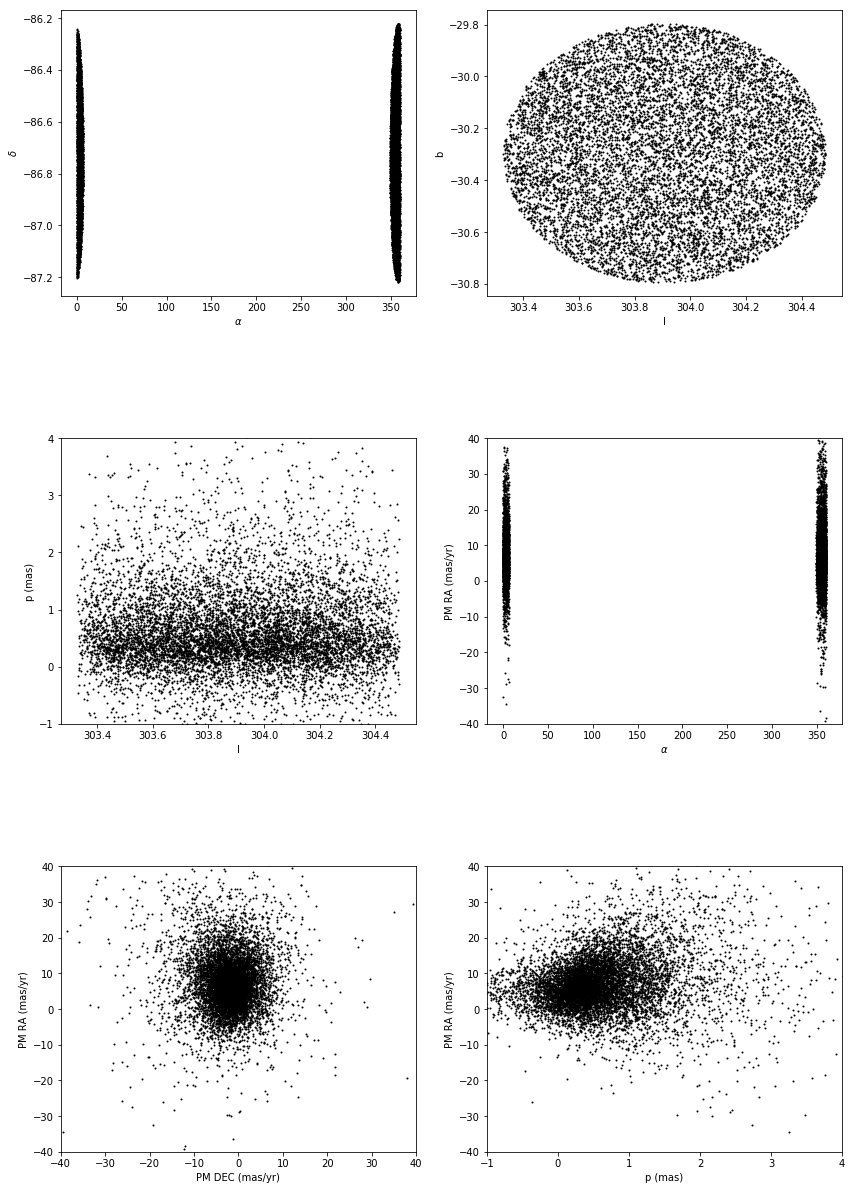

Cluster: MWSC 5684
302.96886308423024
302.9662276444916
-23.77709648116734
-23.769307077862212
## Selected


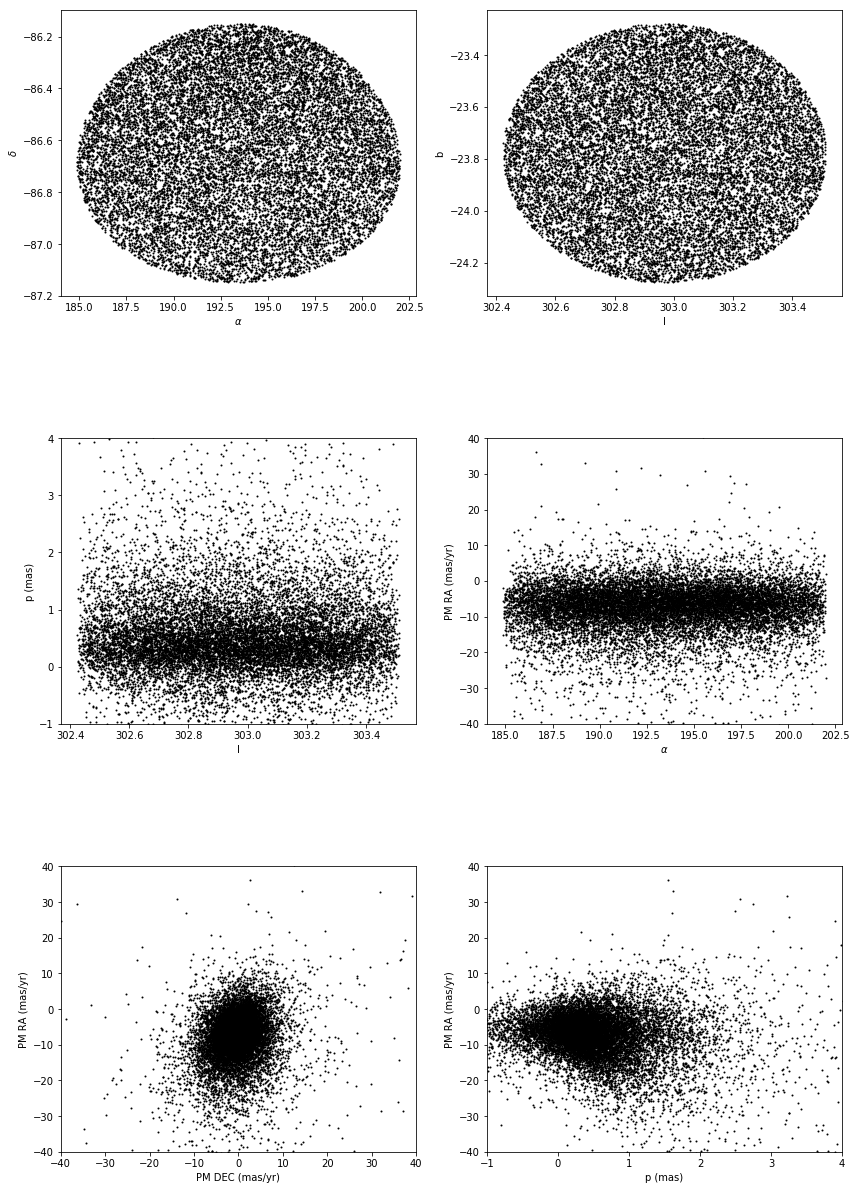

Cluster: MWSC 4176
304.949975954412
304.9501588338228
-22.92878707948923
-22.930613301378308
## Selected


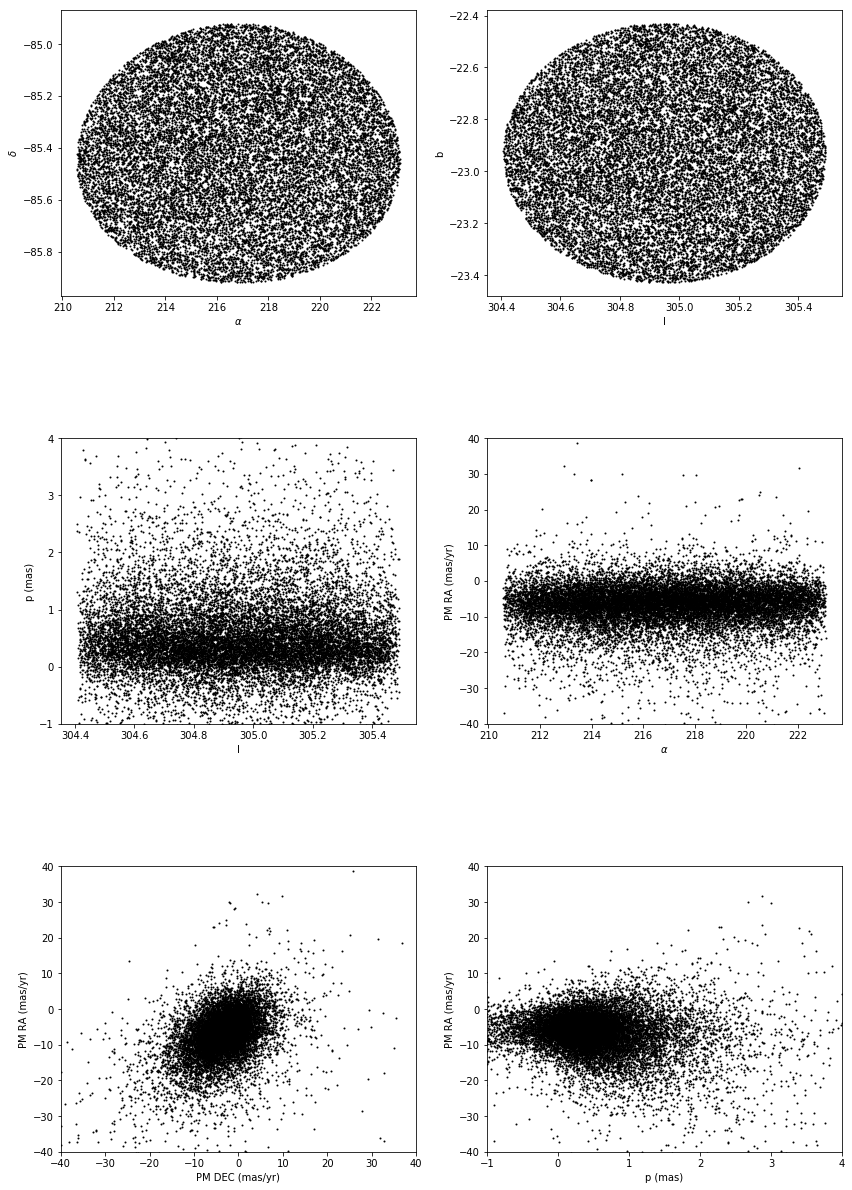

Cluster: ESO 008-06
306.5933198553062
306.5925698992885
-21.483184161747726
-21.47801714461576
## Selected


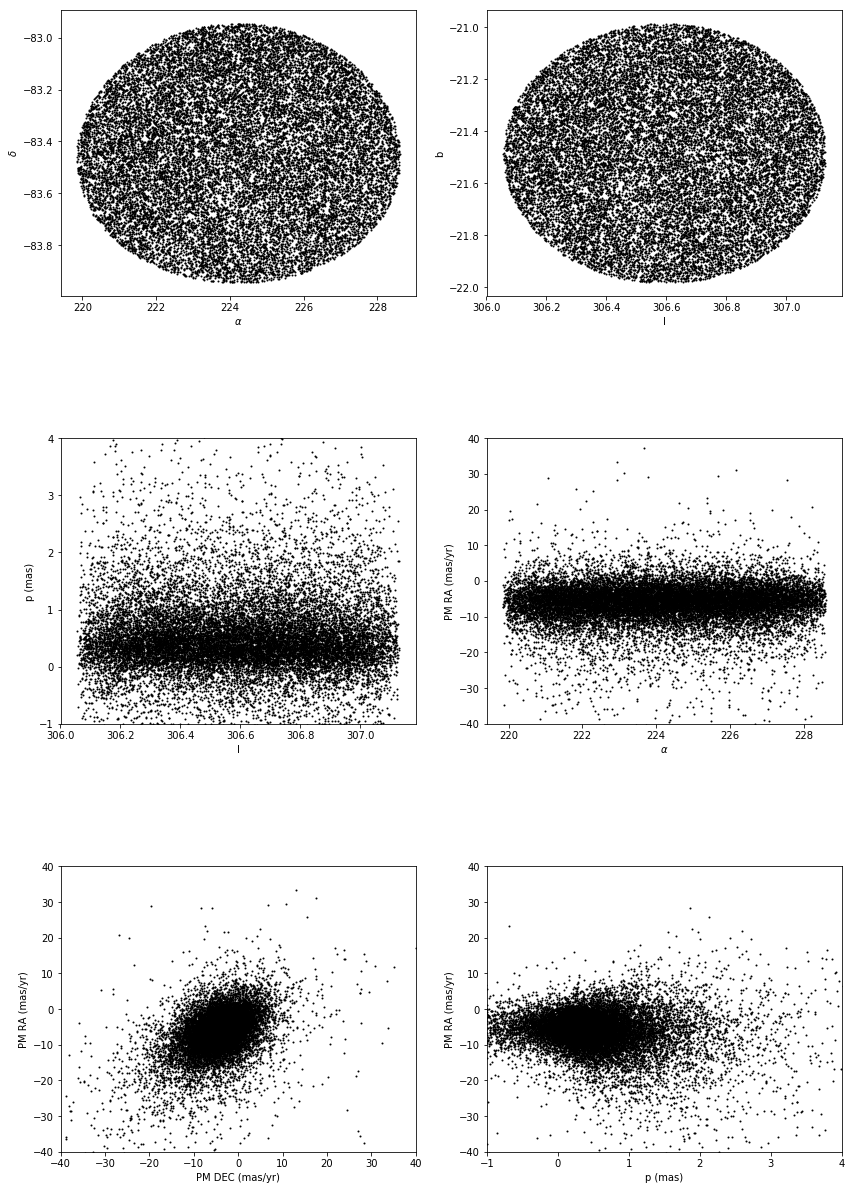

Cluster: MWSC 4219


In [ ]:
# filelist = datadir+"/"+"BrowseTargets.19060.1528915517"
filelist = datadir+"/"+"BrowseTargets.13175.1528937650"
filelist = datadir+"/"+"BrowseTargets.31265.1529958911"
filelist = datadir+"/"+"BrowseTargets.5087.1530044453"

fileoutGaia = wdir + "/"+"BrowseTargets.5087.1530044453.gaia.selected.txt"

# cluster = coord.SkyCoord.from_name("M67")
# cluster = coord.SkyCoord.from_name("NGC2287")
# cluster = coord.SkyCoord.from_name("Collinder 65")

df_cluster = read_cluster_list(filelist)
print(df_cluster.index)
print(df_cluster.columns)

lastSC , lastrow = find_lastSC(fileoutGaia, filelist, df_cluster)

print(lastrow)

for index, row in df_cluster.iloc[lastrow:].iterrows():
    clustername = row['name'].strip()
    print("Cluster: %s"%(clustername))
    
    # c = coord.SkyCoord.from_name(clustername)
    rasplit = row['ra'].split(' ')
    decsplit = row['dec'].split(' ')
    racluster = "%sh%sm%ss"%(rasplit[0],rasplit[1],rasplit[2])
    deccluster = "%sd%sm"%(decsplit[0],decsplit[1])
    c = coord.SkyCoord(racluster, deccluster, frame='icrs')
    
    # Get everything within 1 degree radius of the cluster.
    cluster_candidates = cone_search(c.ra.deg, c.dec.deg, 0.5, table="gaiadr2.gaia_source")
    
    gaia = gu.gaiaSet(cluster_candidates)
    selected = gaia.isHomogeneous(tol = 0.03)
    if selected:
        write_SCgaia(fileoutGaia,row)
        print("## Selected")
    else:
        print("## Not selected")
        
    plotCluster(cluster_candidates, clustername, display = True)


    if len(cluster_candidates) == 0:
        print("## No data...")


### Plots ...